## Age Gender Torch Snippets

In [1]:
from torch_snippets import *
import os
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
import torch
import cv2
import torch.nn as nn
from torch.optim import Adam
from torch_snippets.torch_loader import Report
from torch_snippets.inspector import inspect
from torchsummary import summary
from matplotlib import pyplot as plt
os.environ['TORCH_HOME']='../model'
device='cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
trn_dir=r'../data/Ch5_2/'
val_dir=r'../data/Ch5_2/'
trn_df=pd.read_csv(trn_dir+'fairface_label_train.csv')
val_df=pd.read_csv(val_dir+'fairface_label_val.csv')
trn_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,60,Male,East Asian,True
1,train/2.jpg,30,Female,Indian,False
2,train/3.jpg,6,Female,Black,False
3,train/4.jpg,29,Female,Indian,True
4,train/5.jpg,20,Female,Indian,True


In [3]:
IMAGE_SIZE=224
class GenderAgeClass(Dataset):
    def __init__(self,df,tfms=None,train=True):
        self.df=df
        self.train=train
        self.normalize=transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, item):
        f=self.df.iloc[item].squeeze()
        file=(trn_dir if self.train else val_dir)+f.file
        gen=f.gender=='Female'
        age=f.age
        im=cv2.imread(file)
        im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        return im,age,gen
    def preprocess_image(self,im):
        im=cv2.resize(im,(IMAGE_SIZE,IMAGE_SIZE))
        im=torch.tensor(im).permute(2,0,1)
        im=self.normalize(im/255.)
        return im[None]
    def collate_fn(self,batch):
        """
        preprocess images,ages and genders
        :param batch: 
        :return: 
        """
        ims,ages,genders=[],[],[]
        for im,age,gender in batch:
            im=self.preprocess_image(im)
            ims.append(im)
            ages.append(float(int(age)/80))
            genders.append(float(gender))
        
        ages,genders=[torch.tensor(x).to(device) for x in [ages,genders]]
        ims=torch.cat(ims).to(device)
        return ims,ages,genders

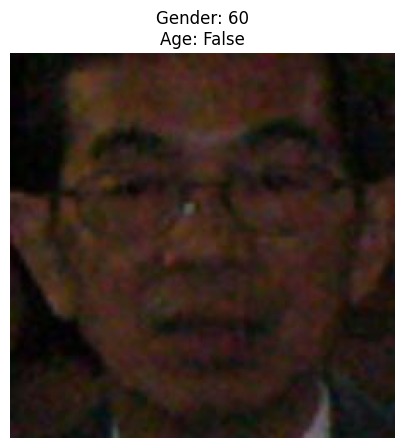

In [4]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)
im, gen, age = trn[0]
show(im, title=f'Gender: {gen}\nAge: {age}', sz=5)

In [5]:
train_loader = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True, collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)

ims, gens, ages = next(iter(train_loader))
inspect(ims, gens, ages)

══════════════════════════════════════════════════════════════════
tensor([[[[-1.3473, -0.3883, -0.3198,  ..., -1.8782, -1.8953, -1.9124],
          [-0.9534, -0.2513, -0.2856,  ..., -1.9124, -1.8953, -1.8782],
          [-0.6109, -0.2856, -0.3369,  ..., -1.9638, -1.9124, -1.8610],
          ...,
          [ 2.2147,  2.1119,  2.0092,  ..., -1.8782, -1.8782, -1.8782],
          [ 2.2147,  2.1119,  1.9920,  ..., -1.9124, -1.9124, -1.9124],
          [ 2.2318,  2.1119,  1.9749,  ..., -1.9467, -1.9467, -1.9638]],

         [[-1.9482, -0.9678, -0.8627,  ..., -1.8081, -1.8606, -1.8782],
          [-1.5455, -0.8277, -0.8277,  ..., -1.8606, -1.8782, -1.8606],
          [-1.1604, -0.8277, -0.8803,  ..., -1.9307, -1.9132, -1.8606],
          ...,
          [ 1.3431,  1.2731,  1.2381,  ..., -1.8081, -1.8081, -1.8081],
          [ 1.3081,  1.2381,  1.1856,  ..., -1.8431, -1.8431, -1.8431],
          [ 1.3081,  1.2031,  1.1331,  ..., -1.8782, -1.8782, -1.8957]],

         [[-1.8044, -0.8807, -0.793

In [6]:
def get_model():
    model=models.vgg16(pretrained=True)
    # Freeze parameters so we don't barkprop through them
    for param in model.parameters():
        # 将模型中所有参数的 requires_grad 属性设置为 False，
        # 这样在反向传播过程中不会对这些参数进行更新，即冻结这些参数。
        param.requires_grad=False
    model.avgpool=nn.Sequential(
        nn.Conv2d(512,512,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier,self).__init__()
            self.intermediate=nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU()
            )
            self.age_classifier=nn.Sequential(
                nn.Linear(64,1),
                nn.Sigmoid()
            )
            self.gender_classifier=nn.Sequential(
                nn.Linear(64,1),
                nn.Sigmoid()
            )
        def forward(self,x):
            x=self.intermediate(x)
            age=self.age_classifier(x)
            gender=self.gender_classifier(x)
            return gender,age
    model.classifier=ageGenderClassifier()
    gender_criterion=nn.BCELoss()
    age_criterion=nn.L1Loss()
    loss_functions=gender_criterion,age_criterion
    optimizer=Adam(model.parameters(),lr=1e-4)
    return model.to(device),loss_functions,optimizer

model,loss_functions,optimizer=get_model()

D:\app\anaconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\app\anaconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
summary(model,input_size=(3,224,224),device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [8]:
def train_batch(data,model,optimizer,criteria):
    model.train()
    ims,age,gender=data
    optimizer.zero_grad()
    pred_gender,pred_age=model(ims)
    gender_criteria,age_criteria=criteria
    gender_loss=gender_criteria(pred_gender.squeeze(),gender)  # 将预测的性别张量从形状中移除单维度，以便与真实性别标签格式一致
    age_loss=age_criteria(pred_age.squeeze(),age)
    total_loss=gender_loss+age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

def validate_batch(data,model,criteria):
    model.eval()
    ims,age,gender=data
    with torch.no_grad():
        pred_gender,pred_age=model(ims)
    gender_criteria,age_criteria=criteria
    gender_loss=gender_criteria(pred_gender.squeeze(),gender)
    age_loss=age_criteria(pred_age.squeeze(),age)
    total_loss=gender_loss+age_loss
    pred_gender=(pred_gender>0.5).squeeze()
    gender_acc=(pred_gender==gender).float().sum()
    age_mae=torch.abs(age-pred_age).float().sum()
    return total_loss,gender_acc,age_mae

EPOCH: 1.000  val_age_mae: 6.334  val_loss: 0.468  val_gender_acc: 0.838  trn_loss: 0.557  (521.01s - 2084.04s remaining)
EPOCH: 2.000  val_age_mae: 6.404  val_loss: 0.449  val_gender_acc: 0.846  trn_loss: 0.405  (1031.09s - 1546.64s remaining)
EPOCH: 3.000  val_age_mae: 6.460  val_loss: 0.489  val_gender_acc: 0.840  trn_loss: 0.288  (1532.17s - 1021.44s remaining)
EPOCH: 4.000  val_age_mae: 6.507  val_loss: 0.662  val_gender_acc: 0.835  trn_loss: 0.201  (2039.73s - 509.93s remaining)
EPOCH: 5.000  val_age_mae: 6.685  val_loss: 0.692  val_gender_acc: 0.834  trn_loss: 0.159  (2550.19s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 562.71it/s]


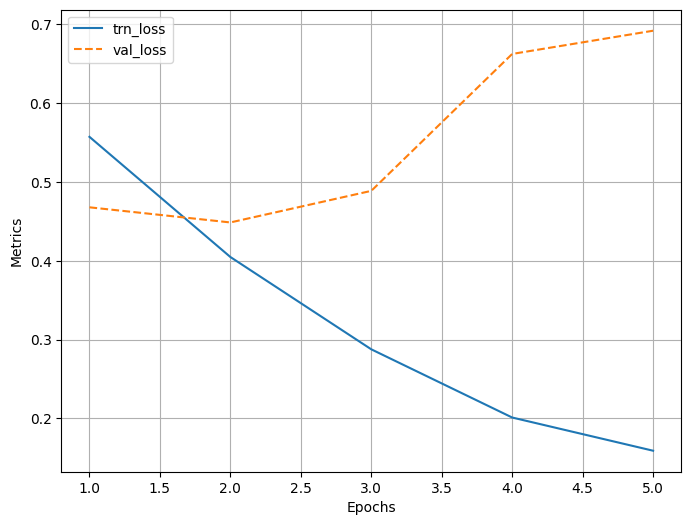

In [9]:
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(train_loader)
    for ix, data in enumerate(train_loader):
        if ix==N:
            break
        total_loss = train_batch(data, model, optimizer, loss_functions)
        log.record(epoch+(ix+1)/N, trn_loss=total_loss, end='\r')

    N = len(test_loader)
    for ix, data in enumerate(test_loader):
        if ix==N:
            break
        total_loss, gender_acc, age_mae = validate_batch(data, model, loss_functions)
        gender_acc /= len(data[0])
        age_mae /= len(data[0])
        log.record(epoch+(ix+1)/N, val_loss=total_loss, val_gender_acc=gender_acc, val_age_mae=age_mae, end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['trn_loss','val_loss'])

predicted gender: Male predicted age: 39


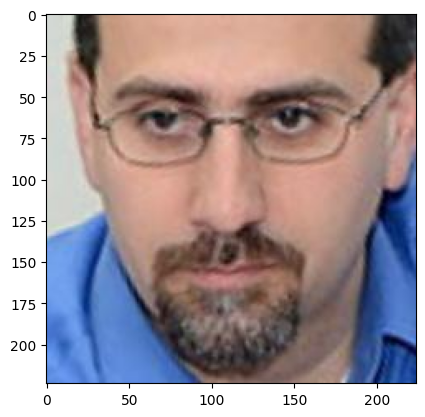

In [10]:
im=cv2.imread(r'../data/Ch5_2/val/10110.jpg')
im=trn.preprocess_image(im).to(device)
gender,age=model(im)
pred_gender=gender.to('cpu').detach().numpy()
pred_age=age.to('cpu').detach().numpy()
im=cv2.imread(r'../data/Ch5_2/val/10110.jpg')
im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(im)
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'),'predicted age:',int(pred_age[0][0]*80))